In [3]:
from langchain_community.utilities import SQLDatabase

usuario = 'postgres'
password = 'place_rag_password'
host = 'localhost'     # o la IP/URL de tu servidor
puerto = '5432'        # puerto por defecto de PostgreSQL
base_datos = 'place_rag_db'

# Crear la URL de conexión
uri = f"postgresql+psycopg2://{usuario}:{password}@{host}:{puerto}/{base_datos}"

db = SQLDatabase.from_uri(uri)

print(db.dialect)                  # Para verificar el tipo de base de datos
print(db.get_usable_table_names()) # Para listar las tablas de la BD
db.run("SELECT * FROM documentos LIMIT 30;")  # Ejemplo de consulta

postgresql
['documentos', 'entidades', 'expedientes', 'paises', 'regiones']


"[('PCAP 50 equipos trabajo en movilidad Anexo I acuerdo MP.pdf', 'https://contrataciondelestado.es/wps/wcm/connect/PLACE_es/Site/area/docAccCmpnt?srv=cmpnt&cmpntname=GetDocumentsById&source=library&DocumentIdParam=0b72a403-f89f-44fe-852d-dcba825cdef4', 'Pliego Administrativo', '2023/20'), ('PPT Suministro 50 portatiles Anexo II acuerdo MP.pdf', 'https://contrataciondelestado.es/wps/wcm/connect/PLACE_es/Site/area/docAccCmpnt?srv=cmpnt&cmpntname=GetDocumentsById&source=library&DocumentIdParam=91b4b1e6-5e64-46e7-8091-27febb59c5fd', 'Pliego Técnico', '2023/20'), ('04 PCAP 35 2023 FIRMADO.pdf', 'https://contrataciondelestado.es/wps/wcm/connect/PLACE_es/Site/area/docAccCmpnt?srv=cmpnt&cmpntname=GetDocumentsById&source=library&DocumentIdParam=8bed1139-4bab-4327-9849-9d3f9ed091f3', 'Pliego Administrativo', 'CON 35/2023 SE AB'), ('03 PPT GRUPOS DE BOMBEO 2023 FIRMADA.pdf', 'https://contrataciondelestado.es/wps/wcm/connect/PLACE_es/Site/area/docAccCmpnt?srv=cmpnt&cmpntname=GetDocumentsById&sour

In [8]:
import ast
import re
import random

def query_as_list(db, query):
    res = db.run(query)
    
    # Verifica si la respuesta contiene 'Decimal('
    if "Decimal(" in res:
        # Extrae todos los números dentro de Decimal('...')
        numbers = re.findall(r"Decimal\('([\d.]+)'\)", res)
        # Convierte las cadenas extraídas a float o Decimal según prefieras
        processed = [float(num) for num in numbers]
    else:
        try:
            # Intenta evaluar la respuesta como una lista de tuplas
            parsed = ast.literal_eval(res)
            # Aplana la lista de tuplas
            flat = [el[0] for el in parsed if el]
            # Aplica limpieza con regex a cadenas de texto
            processed = [re.sub(r"\b\d+\b", "", string).strip() for string in flat]
        except Exception as e:
            raise ValueError(f"Error al evaluar la respuesta de la base de datos: {e}")
    
    # Elimina duplicados
    return list(set(processed))


regiones = query_as_list(db,"SELECT country_subentity_name FROM regiones WHERE country_code = 'ES';")
entidades = query_as_list(db,"SELECT name FROM entidades;")
tipos = query_as_list(db,"SELECT procurement_project_type_code FROM expedientes;")
estados = query_as_list(db,"SELECT contract_folder_status FROM expedientes;")
cuantias = query_as_list(db,"SELECT total_amount FROM expedientes;")

In [9]:
import matplotlib.pyplot as plt
import numpy as np

cuantias_shifted = [amount + 1 for amount in cuantias]
log_cuantias = np.log10(cuantias_shifted)

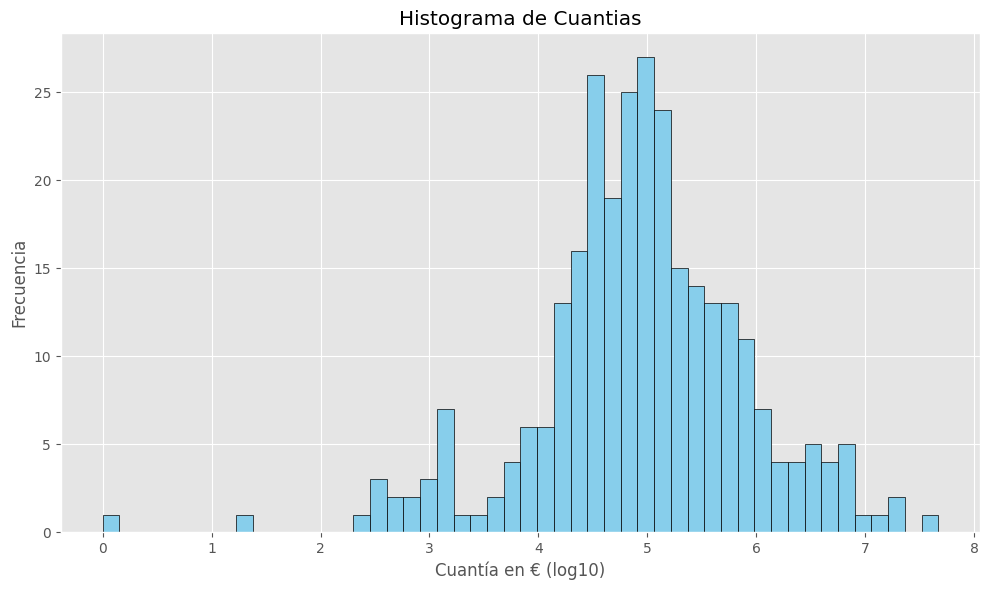

In [ ]:
# Configurar el estilo del gráfico (opcional)
plt.style.use('ggplot')  # Puedes elegir otros estilos como 'seaborn', 'classic', etc.

# Crear el histograma
plt.figure(figsize=(10, 6))  # Tamaño de la figura (ancho, alto) en pulgadas
plt.hist(log_cuantias, bins=50, color='skyblue', edgecolor='black')  # Puedes ajustar el número de bins

# Añadir título y etiquetas
plt.title('Histograma de Cuantías')
plt.xlabel('Cuantía en € (log10)')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.tight_layout()  # Ajusta los espacios para que todo encaje bien
plt.show()
